<a href="https://colab.research.google.com/github/gitnicolas343/intro_neurociencias_Computacionesles_phyton/blob/main/Lab2_Curvas_f_I_VClase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Hodgkin y Huxley

# Cálculo de Curvas f-I

Este notebook tiene como objetivo calcular las curvas $ f-I $ (frecuencia-corriente), así como aprender a hacer análisis de tiempos de disparo.

### Ejercicio 1:

Construir la curva f-I del modelo de HH con los parámetros dados en la clase anterior. A qué tipo de clase de excitabilidad corresponde el modelo de HH con los parámetros estudiados?

In [ ]:
#librerias
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from  scipy.signal import find_peaks

In [ ]:
#parametros
C_m = 1 # uF/cm^2

#conductancias
g_Na = 120 # mS/cm^2
g_K = 36 # mS/cm^2
g_L = 0.3 # mS/cm^2

E_Na = 50 # mV
E_K = -77 # mV
E_L = -50 # mV

In [ ]:
# definicion de  alpha y beta   de h,m,n como funciones para su evaluacion numerica para el modelo de Hudking y HUXLEY
def alpha_n(V):
    return  0.01*(V+55)/(1-np.exp(-(V+55)/10))
def beta_n(V):
    return 0.125*np.exp(-(V+65)/80)
def alpha_m(V):
    return  0.1*(V+40)/(1-np.exp(-(V+40)/10))
def beta_m(V):
    return 4*np.exp(-(V+65)/18)
def alpha_h(V):
    return 0.07*np.exp(-(V+65)/20)
def beta_h(V):
    return 1/(1+np.exp(-(V+35)/10))

In [ ]:
def modelos_Hudkinghuxley(I):   #esta funcion recibe la corriente para iterarla sobre distintos valores de amplitud I

    def I_ext2(t):              #corriente aplicada en el tiempo, funcion a trozos con un condicional if que da una amplitus de 0,5 para el t = 2 y 2,5 de igual forma para 10 y 10,5
        return I

    #reusamos los codigo anteriores pero cambiando I_ext  a I_ext2
    def ecuaciones_a_resolver2(t,X,C_m,g_Na,g_K,g_L,E_Na,E_K,E_L):
        #variables y su posicion en tuplas
        V11 = X[0]
        m11 = X[1]
        n11 = X[2]
        h11 = X[3]
        I_E = I_ext2(t) #pulso de corriente aplicado
        f =(1/C_m)*( I_E - ((g_Na*(m11**3)*h11*(V11-E_Na))+(g_K*(n11**4)*(V11-E_K))+(g_L*(V11-E_L))))  #c_m* dv/dt = Iext−(INa+IK+IL)
        O_n = alpha_n(V11)*(1-n11) - beta_n(V11)*n11  #dn/dt
        O_m = alpha_m(V11)*(1-m11) - beta_m(V11)*m11  #dm/dt
        O_h = alpha_h(V11)*(1-h11) - beta_h(V11)*h11  #dh/dt

        return [f,O_m,O_n,O_h]



    #tiempo de simulacion
    tspan= [0,1000]
    x0 = [-65,0,0,0] #condiciones iniciales

    parametros = (1,120,36,0.3,50,-77,-50)  #parametros
    solucion2 = solve_ivp(ecuaciones_a_resolver2, tspan, x0 , args= parametros,dense_output = True, rtol = 1e-6 ) #solucion numerica
    tiempo_denso = np.linspace(tspan[0],tspan[-1],100000) #tiempo adicional pra efectos de encontrar picos en un millon de pasos

    #obtencion de  segundo parametros
    V2,m2,n2,h2 =solucion2.sol(tiempo_denso)
    return V2,tiempo_denso


In [ ]:
def encontrar_picos(V):                                     #funcion encontrar picos de los spikes

    Peaks_id,_ = find_peaks(V, height= 7)
    Valorespico = V[Peaks_id]
    tiempo_picos = td[Peaks_id]
    return Valorespico,tiempo_picos,Peaks_id

In [ ]:
def frecuencia(tp):

    T_i = np.diff(tp)           # intervalos
    if len(T_i) == 0:           # si find peaks no detecta picos en la funcion de picos por debajo del umbral  no hay intervalos
        return 0
    T_med = np.mean(T_i[1:])
    return 1/T_med              # firing frecuency


In [ ]:
frecuenias_g = []
corrientes = np.arange(6, 40 , 0.01)

for x in corrientes:                          #aqui la variable de iteracion x seria el pulso continuo de la corriente

    v2,td = modelos_Hudkinghuxley(x)          #potencial, tiempo denso del modelo de H.H en la amplitud de corriente dada
    vp,tp,pid = encontrar_picos(v2)
    t = frecuencia(tp)
    frecuenias_g.append(t)


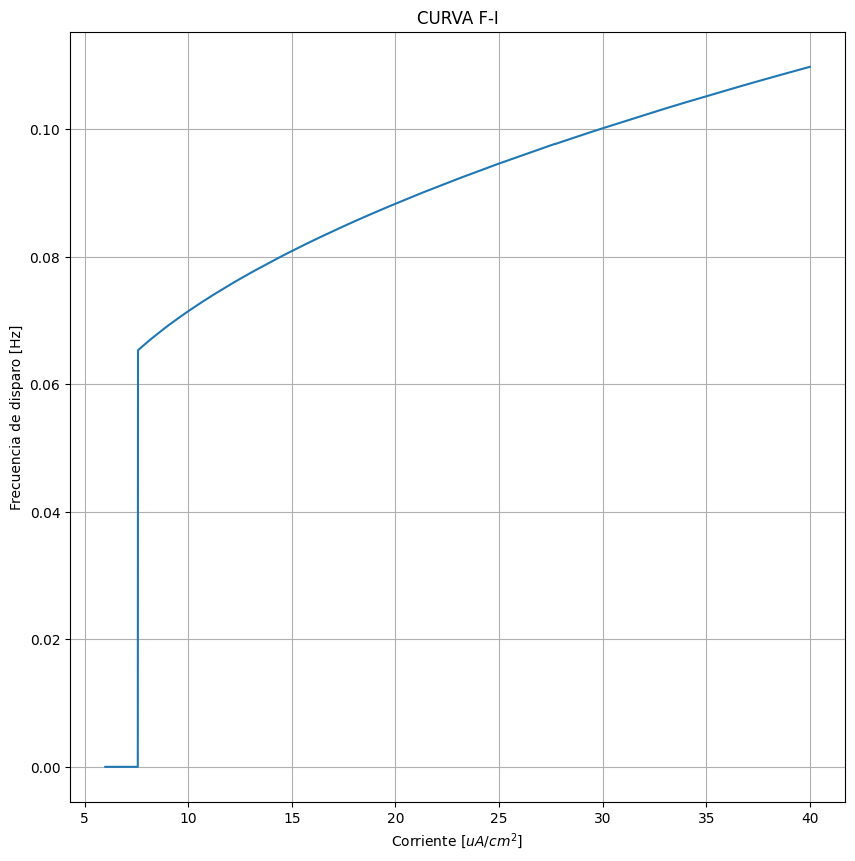

In [ ]:
plt.figure(figsize=(10,10))
plt.title('CURVA F-I')
plt.plot(corrientes,np.array(frecuenias_g) )
plt.grid()
plt.xlabel('Corriente [$uA/cm^2$]')
plt.ylabel('Frecuencia de disparo [Hz]')
plt.show()

# **excitabilidad:**

Este modelo  con los parametros dados corresponde a una neurona de tipo 2, ya  que  al aumentar la corriente inyectada esta permanece en silencio hasta que alcanza un valor umbral y entonces de forma abrupta  comienza a disparar a una frecuencia finita  que en ultimas según la teoría y teniendo en cuenta que depende del inverso de T_i se debe al disparo de los potenciales de acción de forma repetitiva debido al escalón de corriente.

### Ejercicio 2:

A continuación se le presenta un experimento real de electorfisología en el que su colega biólogo ha hecho un experimento aplicando un protocolo de estimulación a una neurona, consistente en varios valores de corriente constante. Su colega le solicita que le indique si la neurona que ha registrado es de tipo I o tipo II.

Realice el análisis para determinarlo. Para ello

1. Compute la curva $f - I$ de esta neurona
2. Muestre dos curvas representativas mostrando cómo es la traza de tiempo del voltaje para una corriente subumbral y una supraumbral.


El dipsoitivo que se usa para hacer registros electrofisiológicos almacena los datos en formato *abf*, para poder leer los datos ejecute el siguiente *snippet*

In [ ]:
!pip install pyabf
import pyabf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
abf = pyabf.ABF('/content/SpikesAndBursts_PFC_Pvalb_APs_01.abf')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Como puede notar el objeto abf importado contiene información sobre 2 canales. Uno mide el potencial de membrana, mientras el otro registra la corriente aplicada, ambas en función del tiempo, con una frecuencia de muestreo de 10kHz. El experimento consiste en 13 *sweeps* o protocolos diferentes. Para acceder a la información del *sweep* i-ésimo, deberá llamar el método

abf.setSweep(i)

Una vez establecido el sweep que desea analizar la información requerida la encontrará en los siguiente atributos:

- tiempo -> abf.sweepX
- voltaje -> abf.sweepY
- corriente -> abf.sweepC

In [ ]:
def encontrar_picos1(V,td1,sencibilidad):   #funcion 2                        #funcion encontrar picos de los spikes modificada

    Peaks_id,_ = find_peaks(V, height= sencibilidad)                          #esta funcion admite un cambio de tiempo y su evalucion, ademas de un umbral donde no contara picos
    Valorespico = V[Peaks_id]
    tiempo_picos = td1[Peaks_id]
    return Valorespico,tiempo_picos,Peaks_id                                   #tiene el mismo retorno que la funcion anterior

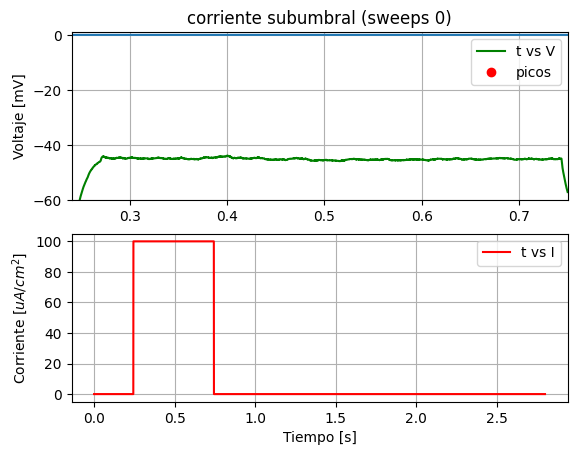

In [ ]:
#buscando el umbral para picos

abf.setSweep(0)                     #seleccion de sweet
tiempo = abf.sweepX                 #extraccion de variables
voltaje = abf.sweepY
corriente = abf.sweepC
linea= [0]*len(tiempo)
Valorespico1,tiempo_picos1,Peaks_id1 = encontrar_picos1(voltaje,tiempo,0)   #encontrando picos, asigno un umbral muy bajo para ver que sucede


plt.subplot(2,1,1)
plt.title('corriente subumbral (sweeps 0)')
plt.plot(tiempo,linea)
plt.plot(tiempo, voltaje, color = 'g', label = 't vs V')
plt.plot(tiempo_picos1,Valorespico1, 'o', color = 'red', label = 'picos') #no hay picos por el umbral programado previamente
plt,plt.legend()
plt.xlim(0.24,0.75)
plt.ylim(-60,1)
plt.ylabel('Voltaje [mV]')
plt.grid()


plt.subplot(2,1,2)
plt.plot(tiempo, corriente, color = 'r', label = 't vs I')
plt.legend()
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente $[uA/cm^2]$')
plt.grid()
plt.show()


#gran cantidad de puntos que no corresponden a spikes


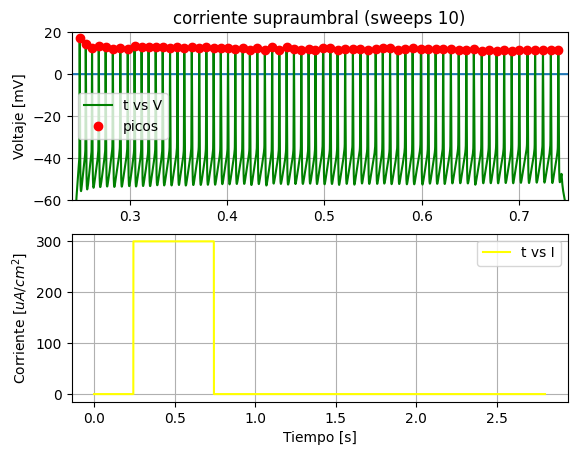

In [ ]:
abf.setSweep(10)                     #seleccion de sweet
tiempo = abf.sweepX                 #extraccion de variables
voltaje = abf.sweepY
corriente = abf.sweepC
linea= [0]*len(tiempo)
Valorespico1,tiempo_picos1,Peaks_id1 = encontrar_picos1(voltaje,tiempo,0)   #encontrando picos, asigno un umbral muy bajo para ver que sucede


plt.subplot(2,1,1)
plt.title('corriente supraumbral (sweeps 10)')
plt.plot(tiempo,linea)
plt.plot(tiempo, voltaje, color = 'g', label = 't vs V')
plt.plot(tiempo_picos1,Valorespico1, 'o', color = 'red', label = 'picos')
plt,plt.legend()
plt.xlim(0.24,0.75)
plt.ylim(-60,20)
plt.ylabel('Voltaje [mV]')
plt.grid()


plt.subplot(2,1,2)
plt.plot(tiempo, corriente, color = 'yellow', label = 't vs I')

plt.legend()
plt.xlabel('Tiempo [s]')
plt.ylabel('Corriente $[uA/cm^2]$')
plt.grid()
plt.show()


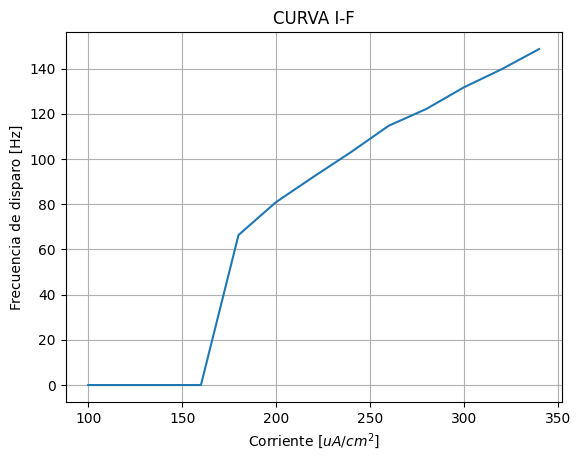

In [ ]:
frecuencia_V2 = list()     #almacenamiento de datos despues de cada iteracion
corriente_total= list()

#CICLO QUEITERA SOBRE TODOS LOS SWEEP DEL ENCEFALOGRAMA
for i in range(0,13,1):

    abf.setSweep(i)                                                             #escojemos el sweep en funcion de i
    tiempo = abf.sweepX                                                         #extraccion de variables
    voltaje = abf.sweepY
    corriente = abf.sweepC


    Valorespico1,tiempo_picos1,Peaks_id1 = encontrar_picos1(voltaje,tiempo,0) #usamos la funcion reciclada de encontrar picos modificada para asignar umbral y tiempo
    frecuencia_V2.append(frecuencia(tiempo_picos1))                             #reciclamos la funcion de frecuencia para firing frecuency
    corriente_total.append(max(corriente))                                      #hallamos los maximos de corriente


#GRAFICA

plt.plot(corriente_total,frecuencia_V2)
plt.title('CURVA I-F')
plt.grid()
plt.xlabel('Corriente [$uA/cm^2$]')
plt.ylabel('Frecuencia de disparo [Hz]')
plt.show()



# **tipo de neurona:**
debido a la grafica se puede odservar que tenemos una neurona de tipo 1 debido a que la frecuencia aumenta de manera suave desde el umbral de 0 comforme aumenta la corriente subre el umbral, aunque comienza en cero la frecuencia aumenta de forma suave.